# Siamese network 생성

Siamese = 샴

multi-input 모델을 생성하도록 하겠습니다.

이번 실습에서는 두개의 이미지 input을 받아서 **유사도를 측정하는 모델을 생성**합니다.

- input: 2 개의 이미지 입력
- output: 1 개의 결과 (similarity)

## import

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## 데이터셋 준비

시각화 및 데이터셋을 구성합니다.

In [21]:
def create_pairs(x, digit_indices):
    '''
    Positive, Negative Pair를 생성합니다.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

In [22]:
def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [23]:
# 시각화
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

Paired 데이터셋 준비

In [24]:
# load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize values
x_train = x_train / 255.0
x_test = x_test / 255.0

# create pairs on train and test sets
train_pairs, train_y = create_pairs_on_set(x_train, y_train)
test_pairs, test_y = create_pairs_on_set(x_test, y_test)

You can see a sample pair of images below.

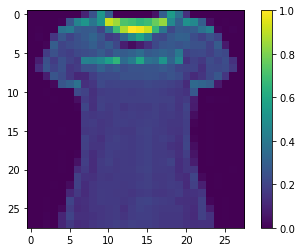

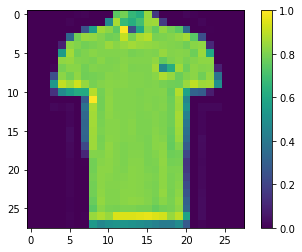

1.0


In [25]:
# 샘플 index에 대한 시각화
idx = 8

# 이미지 시각화
show_image(test_pairs[idx][0])
show_image(test_pairs[idx][1])

# label print
print(train_y[idx])

1.0


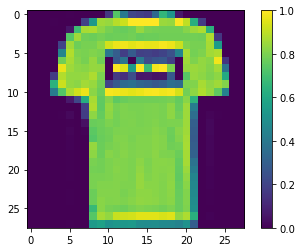

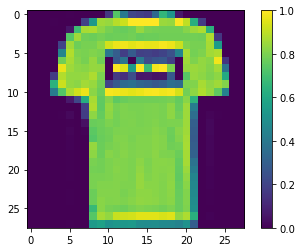

0.0


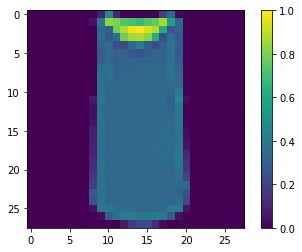

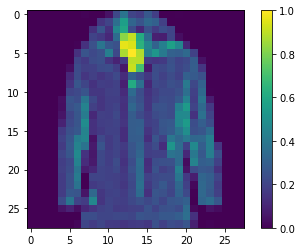

In [27]:
# print other pairs
print(train_y[0])
show_image(train_pairs[:,0][0])
show_image(train_pairs[:,0][1])

print(train_y[1])
show_image(train_pairs[:,1][0])
show_image(train_pairs[:,1][1])

## 모델 생성

base가 되는 network를 생성합니다.

In [8]:
def initialize_base_network():
    input_ = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input_)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)
    return Model(inputs=input_, outputs=x)


def euclidean_distance(inputs):
    x1, x2 = inputs
    sum_square = K.sum(K.square(x1 - x2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

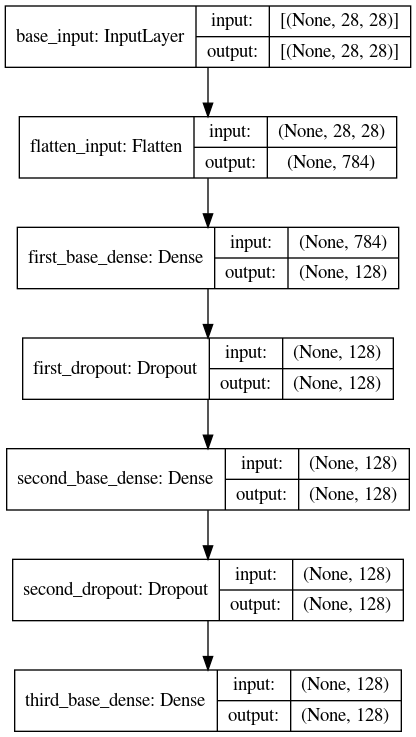

In [9]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Siamese Network를 생성합니다.

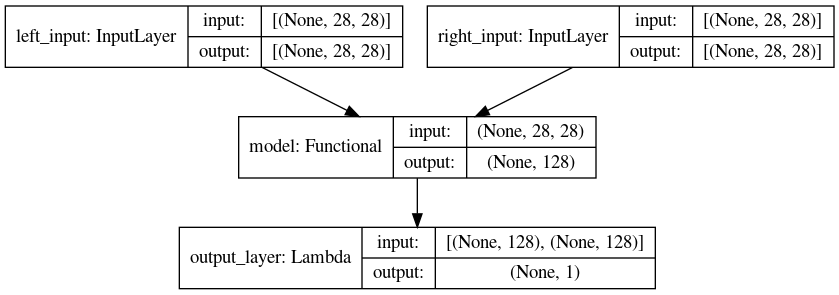

In [10]:
# left input과 base_network를 연결합니다.
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# right input과 base_network를 연결합니다.
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# lambda를 사용하여 2개의 outputs 간 euclidean_distance를 구합니다.
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# model의 inputs와 output을 정의합니다.
model = Model([input_a, input_b], output)

# plot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## 모델 훈련

모델 훈련시 Contrastive Loss를 활용합니다. 논문은 아래 링크를 참고하시면 됩니다.

**Contrastive loss from Hadsell-et-al.'06**

[논문링크](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

Loss Funciton은 Keras의 백엔드 엔진을 활용하여 구현합니다.

In [11]:
from IPython.display import Image as ImageURL

In [12]:
ImageURL(url='https://miro.medium.com/max/700/1*g8TVcxgVigHtYEmYilsfQw.png', width=500)

**term**
- Dw: prediction
- Y: label

In [13]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [14]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer='rmsprop')
history = model.fit([train_pairs[:,0], 
                     train_pairs[:,1]], 
                    train_y, 
                    epochs=20, 
                    batch_size=128, 
                    validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1574 - val_loss: 0.0902
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0835 - val_loss: 0.0744
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0736 - val_loss: 0.0744
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0675 - val_loss: 0.0676
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0638 - val_loss: 0.0691
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0608 - val_loss: 0.0653
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0592 - val_loss: 0.0632
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0570 - val_loss: 0.0665
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0566 - val_loss: 0.0624
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0547 - val_loss: 0.0674

## 평가(Evaluation)

In [15]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [16]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_y)

y_pred_trainain = model.predict([train_pairs[:,0], train_pairs[:,1]])
trainain_accuracy = compute_accuracy(train_y, y_pred_trainain)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

print("Loss = {}, trainain Accuracy = {} Test Accuracy = {}".format(loss, trainain_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0651
Loss = 0.06505091488361359, trainain Accuracy = 0.06464410735122521 Test Accuracy = 0.08898898898898899


## Loss 시각화

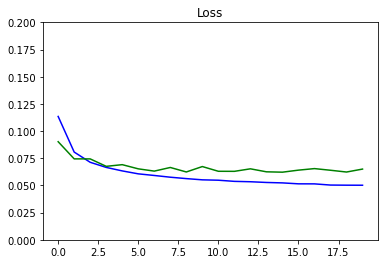

In [17]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [18]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

## 샘플 출력

In [19]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "clothes and their dissimilarity", 10)

NameError: name 'y_pred_train' is not defined